In [1]:
!pip install statsforecast

In [32]:
import pandas as pd
from statsforecast import StatsForecast

In [33]:
initial_data = pd.read_csv('IE_KPMG_Demand_Forecast_dataset.csv', delimiter = ';')
initial_data.head()

year_week  ID_material Units
0   2019-11    120010970   540
1   2019-12    120010970   750
2   2019-13    120010970   960
3   2019-14    120010970   720
4   2019-15    120010970  1620

In [34]:
df = initial_data.sort_values('year_week')

In [35]:
df.dtypes

year_week      object
ID_material     int64
Units          object
dtype: object

In [6]:
df = df.rename(columns={'year_week': 'ds', 'ID_material': 'unique_id', 'Units': 'y'})

In [7]:
df['y'] = df['y'].str.replace('[^0-9]', '', regex=True)   #eliminate any space that the dataset can have 

In [8]:
unique_ids = df['unique_id'].nunique()

# Print the count
print("Number of unique IDs:", unique_ids)

Number of unique IDs: 14


In [37]:
#the resulting datetime object represents the start of each week (specifically Monday) for the corresponding year and week in the original 'year_week' format
df['year_week'] = pd.to_datetime(df['year_week'] + '-1', format='%Y-%W-%w')

df['year_week']

1381   2017-01-09
1382   2017-01-16
1383   2017-01-23
1384   2017-01-30
1385   2017-02-06
          ...    
1142   2022-09-26
909    2022-09-26
460    2022-09-26
303    2022-09-26
2856   2022-09-26
Name: year_week, Length: 2857, dtype: datetime64[ns]

In [10]:
df.dtypes

ds           datetime64[ns]
unique_id             int64
y                    object
dtype: object

In [11]:
df['y'] = pd.to_numeric(df['y'], errors='coerce')   #y has to be as an numeric, so i changed.

In [12]:
df.dtypes                    #now, we can use the StatsForecast.

ds           datetime64[ns]
unique_id             int64
y                     int64
dtype: object

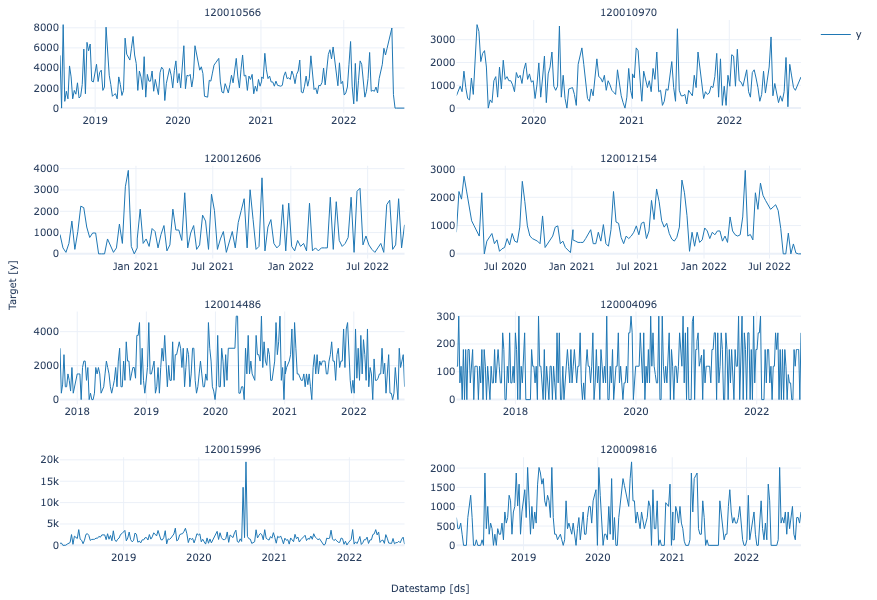

In [13]:
#this prints 8 random 

StatsForecast.plot(df)

## Train multiple models for many series

In [14]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)


# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=24),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]

In [15]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df, 
    models=models,
    freq='W',
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

In [16]:
forecasts_df = sf.forecast(h=8, level=[90])   #h=9 because its 2 months forecast

forecasts_df.head()

ds   AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
unique_id                                                            
120004096 2022-10-02   98.879623       -44.100891       241.860138   
120004096 2022-10-09  125.555779       -19.379553       270.491119   
120004096 2022-10-16  120.513153       -24.631294       265.657593   
120004096 2022-10-23  121.466370       -23.689636       266.622375   
120004096 2022-10-30  121.286179       -23.899952       266.472321   

           HoltWinters  HoltWinters-lo-90  HoltWinters-hi-90  CrostonClassic  \
unique_id                                                                      
120004096        180.0        -112.870514         472.870514      114.753853   
120004096        120.0        -172.870514         412.870514      114.753853   
120004096        180.0        -112.870514         472.870514      114.753853   
120004096        180.0        -112.870514         472.870514      114.753853   
120004096        180.0        -112.870514         472.870514      114.753853   

           SeasonalNaive  SeasonalNaive-lo-90  SeasonalNaive-hi-90  \
unique_id                                                            
120004096          120.0           -84.214935           324.214935   
120004096          240.0            35.785069           444.214935   
120004096          180.0           -24.214933           384.214935   
120004096          240.0            35.785069           444.214935   
120004096            0.0          -204.214935           204.214935   

           HistoricAverage  HistoricAverage-lo-90  HistoricAverage-hi-90  \
unique_id                                                                  
120004096       114.280937             -30.833893             259.395752   
120004096       114.280937             -30.833893             259.395752   
120004096       114.280937             -30.833893             259.395752   
120004096       114.280937             -30.833893             259.395752   
120004096       114.280937             -30.833893             259.395752   

           DynamicOptimizedTheta  DynamicOptimizedTheta-lo-90  \
unique_id                                                       
120004096             118.118317                   -16.637192   
120004096             118.118317                   -37.103882   
120004096             118.118317                   -67.718353   
120004096             118.118317                   -36.193432   
120004096             118.118317                   -11.670474   

           DynamicOptimizedTheta-hi-90  
unique_id                               
120004096                   288.087921  
120004096                   245.618423  
120004096                   260.332642  
120004096                   245.281921  
120004096                   276.540558

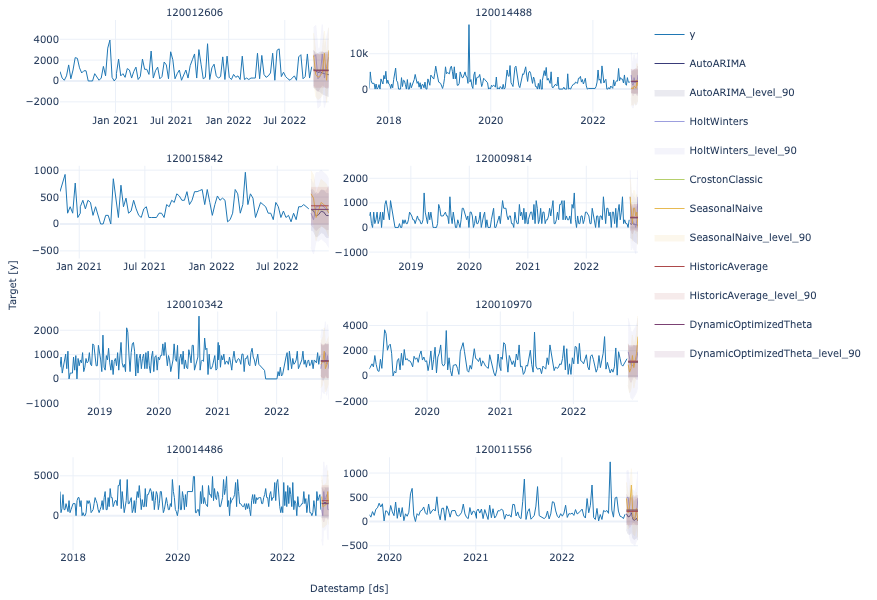

In [17]:
sf.plot(df,forecasts_df)

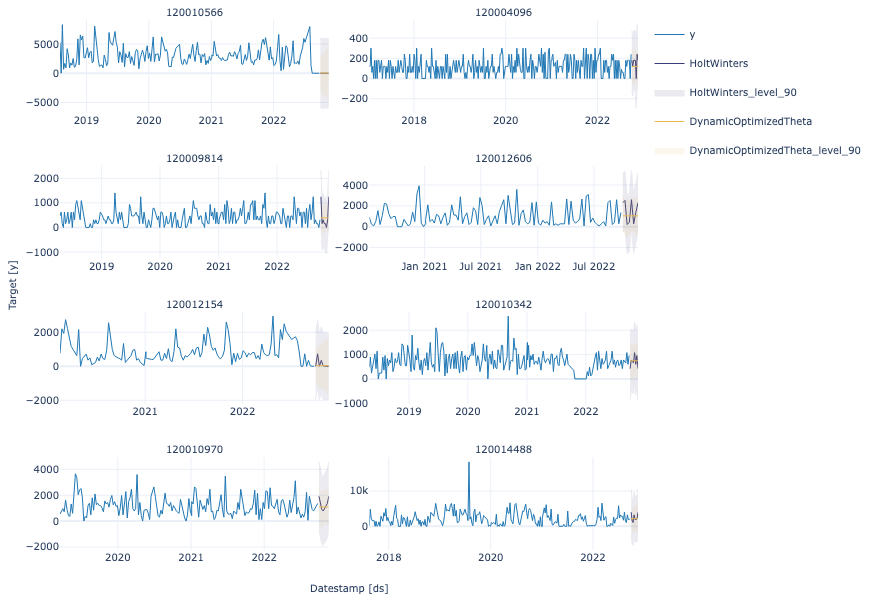

In [18]:
# Plot to unique_ids and some selected models
sf.plot(df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"])

In [19]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=24,
    step_size=24,
    n_windows=2
  )

In [20]:
crossvaldation_df.head()

ds     cutoff      y   AutoARIMA  HoltWinters  \
unique_id                                                         
120004096 2021-10-31 2021-10-24    0.0  109.128365        300.0   
120004096 2021-11-07 2021-10-24  240.0  117.292809          0.0   
120004096 2021-11-14 2021-10-24  240.0  122.554436        120.0   
120004096 2021-11-21 2021-10-24    0.0  125.945320        300.0   
120004096 2021-11-28 2021-10-24  180.0  128.130600          0.0   

           CrostonClassic  SeasonalNaive  HistoricAverage  \
unique_id                                                   
120004096      137.027664           60.0       113.067726   
120004096      137.027664          120.0       113.067726   
120004096      137.027664          240.0       113.067726   
120004096      137.027664          180.0       113.067726   
120004096      137.027664            0.0       113.067726   

           DynamicOptimizedTheta  
unique_id                         
120004096             141.421326  
120004096             141.421326  
120004096             141.421326  
120004096             141.421326  
120004096             141.421326

In [21]:
!pip install datasetsforecast

In [22]:
from datasetsforecast.losses import mse, mae, rmse


def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [23]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)

evaluation_df

AutoARIMA   HoltWinters  CrostonClassic  SeasonalNaive  \
unique_id                                                              
120004096  9.097906e+03  2.341875e+04    9.106951e+03   2.056875e+04   
120009814  1.140272e+05  2.476695e+05    1.291404e+05   2.356282e+05   
120009816  3.217115e+05  3.283200e+05    2.108518e+05   4.121280e+05   
120010342  1.058723e+05  1.591542e+05    1.652079e+05   3.819146e+05   
120010566  4.752756e+06  6.385909e+06    4.884188e+06   7.148387e+06   
120010970  9.878651e+05  8.372531e+05    5.590722e+05   1.415072e+06   
120011556  7.578317e+04  7.410236e+04    4.395093e+04   6.169652e+04   
120011782  6.346734e+05  8.844214e+05    6.259030e+05   7.460454e+05   
120012154  7.678038e+05  7.037196e+05    6.026762e+05   8.123295e+05   
120012606  2.258924e+06  2.925326e+06    1.153625e+06   2.198798e+06   
120014486  1.580349e+06  2.496501e+06    1.644587e+06   3.090859e+06   
120014488  2.996511e+06  6.109137e+06    2.438348e+06   3.941884e+06   
120015842  7.667489e+04  9.450833e+04    4.534874e+04   8.118334e+04   
120015996  1.584220e+06  1.452739e+06    8.915441e+05   1.474803e+06   

           HistoricAverage  DynamicOptimizedTheta             best_model  
unique_id                                                                 
120004096     9.150406e+03           9.144143e+03              AutoARIMA  
120009814     9.331061e+04           1.293433e+05        HistoricAverage  
120009816     2.205846e+05           2.728934e+05         CrostonClassic  
120010342     1.926052e+05           1.323251e+05              AutoARIMA  
120010566     4.920156e+06           5.347688e+06              AutoARIMA  
120010970     4.918718e+05           5.590600e+05        HistoricAverage  
120011556     4.200698e+04           4.395093e+04        HistoricAverage  
120011782     8.293878e+05           6.264331e+05         CrostonClassic  
120012154     5.744908e+05           6.260929e+05        HistoricAverage  
120012606     9.484346e+05           1.154143e+06        HistoricAverage  
120014486     1.553077e+06           1.513081e+06  DynamicOptimizedTheta  
120014488     2.618588e+06           2.540340e+06         CrostonClassic  
120015842     4.052729e+04           4.980259e+04        HistoricAverage  
120015996     1.153414e+06           8.943728e+05         CrostonClassic

In [24]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()

summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]


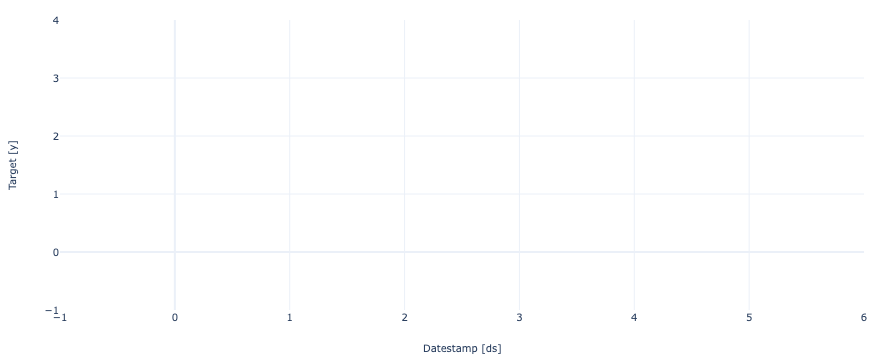

In [25]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"').index

sf.plot(df,forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

In [26]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

In [27]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

prod_forecasts_df.head()

model             ds  best_model  best_model-hi-90  best_model-lo-90
unique_id                                                           
120004096 2022-10-02   98.879623        241.860138        -44.100891
120004096 2022-10-09  125.555779        270.491119        -19.379553
120004096 2022-10-16  120.513153        265.657593        -24.631294
120004096 2022-10-23  121.466370        266.622375        -23.689636
120004096 2022-10-30  121.286179        266.472321        -23.899952

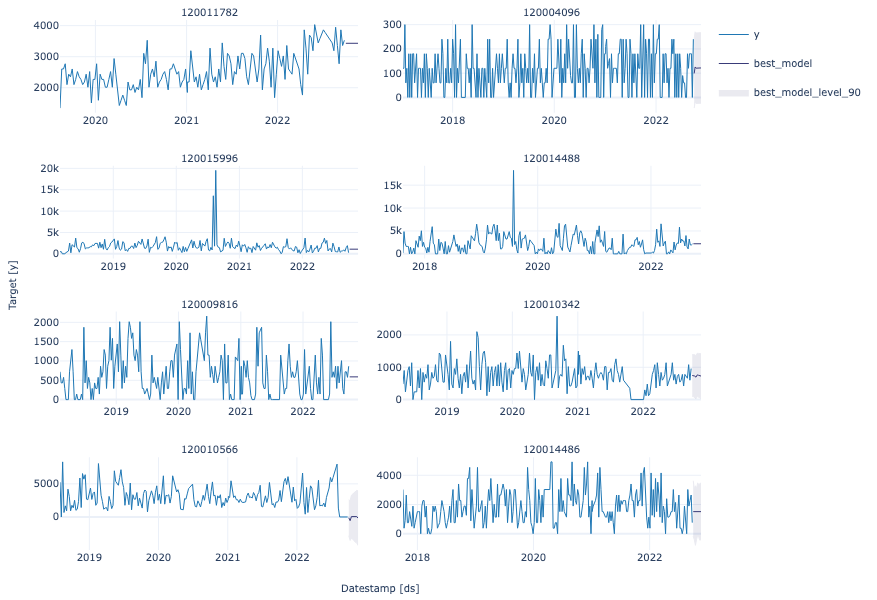

In [28]:
sf.plot(df, prod_forecasts_df, level=[90])

In [29]:
df['unique_id']=120004096

In [30]:
df

ds  unique_id     y
1381 2017-01-09  120004096   120
1382 2017-01-16  120004096   120
1383 2017-01-23  120004096   300
1384 2017-01-30  120004096    60
1385 2017-02-06  120004096   120
...         ...        ...   ...
1142 2022-09-26  120004096   312
909  2022-09-26  120004096   960
460  2022-09-26  120004096   150
303  2022-09-26  120004096  1365
2856 2022-09-26  120004096   276

[2857 rows x 3 columns]

In [38]:
# Export the DataFrame to Excel
df.to_excel('KPMGFinal.xlsx', sheet_name='Sheet1', index=False)
